# Tutorial 3: A one-asset HANK model

In this notebook we solve the one-asset HANK model from Auclert, Bardóczy, Rognlie, Straub (2021): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models" ([link to their paper](https://www.bencebardoczy.com/publication/sequence-jacobian/sequence-jacobian.pdf)).

I have removed almost all of the markdown cells and print statements to be as conscise as possible. Visit their [GitHub page](https://github.com/shade-econ/sequence-jacobian) to see the unedited original/more context. 

The purpose of this notebook is to see what is happening in this model at the individual and household level following a one-time shock to interest rates. Many of the responses are peculiar. 

The only change we make is that we allow for borrowing, more specifically a borrowing limit that ex post results in the number of asset gridpoints where assets are negative the same as when they are positive. This required some calibration because the code is designed to handle the non-ignorable non-linear behavior at the borrowing limit by putting more gridpoints there. There will be a short discussion of how allowing for borrowing changes the results. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, create_model  # functions
from sequence_jacobian import hetblocks, grids      # modules

## Model description

The model is a HA version of the textbook New Keynesian model. Technology is linear in labor, prices are sticky á la Rotemberg, and monetary policy follows a Taylor rule. The model can be summarized in sequence form as

$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t L_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t L_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{N}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

where the endogenous variables are $\textbf{X} = (Y, L, r, w, d, \pi, \tau, i)$ and the exogenous variables are $\textbf{Z}=(r^*, Z)$. 

The asset demand and labor supply functions $\{\mathcal{A}, \mathcal{L}\}$ follow from the household block with Bellman equation

$$
\begin{align} \tag{HH}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \mathbb{E}_t\left[V_{t+1}(e', a)|e \right] \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t e n - \tau_t \bar{\tau}(e) + d_t \bar{d}(e)
\\
a &\geq 0
\end{align}
$$

where $\bar\tau(e)$ and $\bar d(e)$ are skill-specific incidence rules for taxes and dividends. 

We can think of the model as a directed acyclical graph (DAG) with **3 endogenous inputs** and write it as an implicit function

$$
H(\pi, Y, w; \epsilon, Z) = 0.
$$

In [46]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, create_model  # functions
from sequence_jacobian import hetblocks, grids      # modules

hh = hetblocks.hh_labor.hh

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, pi_e, Pi, a_grid


def transfers(pi_e, Div, Tax, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = e_grid, e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

def wages(w, e_grid):
    we = w * e_grid
    return we

hh1 = hh.add_hetinputs([make_grid, transfers, wages])

def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

hh_ext = hh1.add_hetoutputs([labor_supply])

@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r


@simple
def fiscal(r, B):
    Tax = r * B
    return Tax


@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt


@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

blocks_ss = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc_ss]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

calibration = {'eis': 0.5, 'frisch': 0.5, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': -5.8788, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'B': 5.6}

unknowns_ss = {'beta': 0.986, 'vphi': 0.8}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

#plt.plot(ss0.internals['hh']['a_grid'], ss0.internals['hh']['n'].T)
#plt.xlabel('Assets'), plt.ylabel('Labor supply')
#plt.show()

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res


blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

# Modifications 

### 4.3 Results

Now let's consider 25 basis point (<span style="color:red;">contractionary</span>) monetary policy shocks with different persistences and plot the response of inflation.

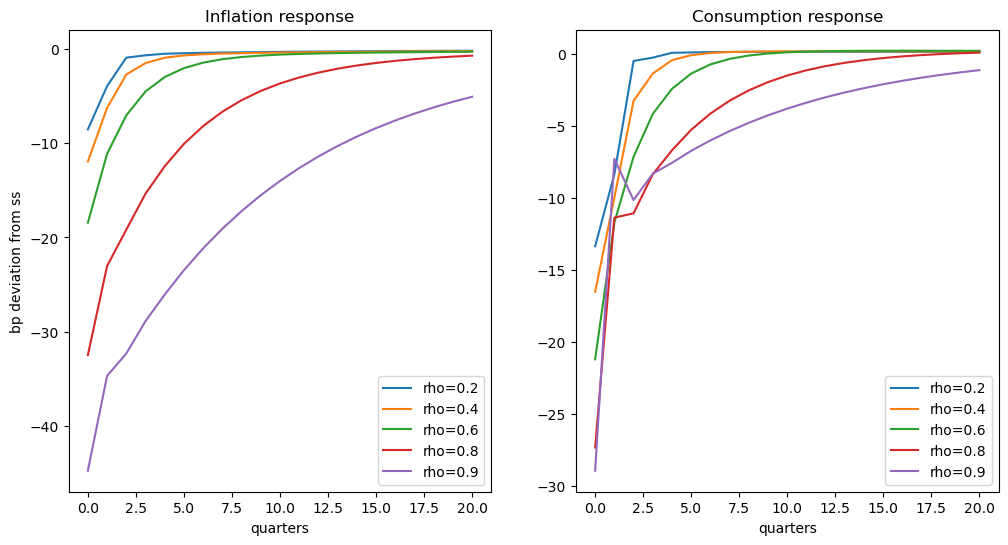

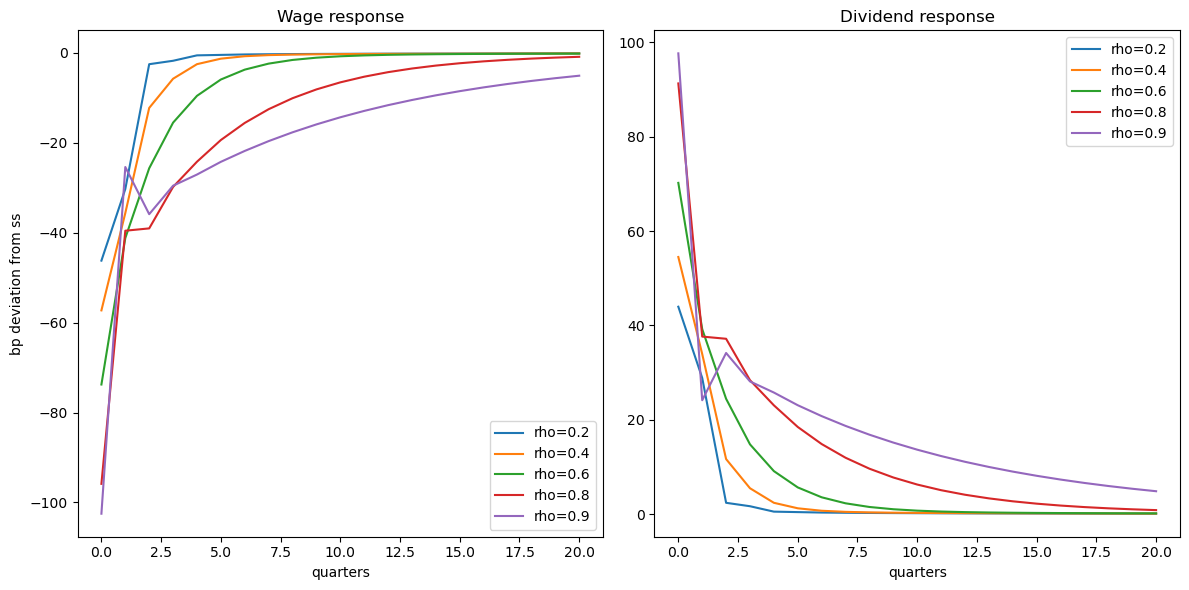

In [47]:
import matplotlib.pyplot as plt
import numpy as np

rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])

drstar = 0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = 10000 * G['pi']['rstar'] @ drstar
dci = 10000 * G['C']['rstar'] @ drstar
ddi = 10000 * G['Div']['rstar'] @ drstar
dwi = 10000 * G['w']['rstar'] @ drstar

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for rho_value in rhos:
    plt.plot(dpi[:21, rhos.tolist().index(rho_value)], label=f'rho={rho_value}')
plt.title(r'Inflation response')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.legend()

plt.subplot(1, 2, 2)
for rho_value in rhos:
    plt.plot(dci[:21, rhos.tolist().index(rho_value)], label=f'rho={rho_value}')
plt.title('Consumption response')
plt.xlabel('quarters')
plt.legend()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for rho_value in rhos:
    plt.plot(dwi[:21, rhos.tolist().index(rho_value)], label=f'rho={rho_value}')
plt.title(r'Wage response')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.legend()

plt.subplot(1, 2, 2)
for rho_value in rhos:
    plt.plot(ddi[:21, rhos.tolist().index(rho_value)], label=f'rho={rho_value}')
plt.title('Dividend response')
plt.xlabel('quarters')
plt.legend()

plt.tight_layout()
plt.show()

Implication: as we increase the persistence of a MP shock, the marginal effect on the change in inflation becomes increasingly higher than the m.e on consumption (note: not shown but the same implication holds for expansionary shock). 

Another interesting point is the massive (relative to inflation and consumption) responses we see to real wages and dividends -- this seems highly counterfactual. It's important to note that some of the authors of this toolbox seperately advocate for wage rigities instead of price rigities (shown here) when using HANK

Overall, we can use the Firm side to try to make sense of some of these effects 

$$\log(1 + \pi_t) = \kappa \left( \frac{w_t}{F'(N_t)} - \frac{1}{\mu} \right) + \frac{1}{1 + r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1 + \pi_{t+1})$$

$$d_t = Y_t - w_tN_t - \psi_t, \ \psi_t = \gamma \log(1+\pi_t)^2 Y_t$$

Given that the difference between output and consumption response is very small and inflation is 0 at the steady state, $Y_t - \psi_t \downarrow$. So the fall in wage expinditures accounts for the large rise in dividends. 

Additionally, we are simulating a shock to $r_t$ here, which in the context of the Firm's problem is the discount rate for future profits. Just as (all else equal) a higher $\rho$ (rate of time preference) on the household side implies a higher interest rate for the same savings motive, a higher interest rate implies future profit is discounted more. 

This structure implies inflation is pinned down by future marginal payoffs. That is, the marginal cost of changing price today must equal to the discounted sum of extra payoff in the future. This is a deterministic model, so following a one-time shock Firms have perfect foresight of what will happen in the future. Going back to the point on persistence, firms have a competing motive: a more persistent shock implies longer stretches of non-trivial markup/marginal cost deviations (and therefore want to change prices a lot immediately to minimize future adjustment costs) but it also reduces how much firm's care about incurring future costs (justifying a less intense initial adjustment). However, we see here the effect of the former dominates as persistence grows.  

The other equations that pin down a GE solution are market clearing (WLOG asset and labor). Therefore, the fixed supply assumption for assets will turn out to be critical. Because the return on saving has been changed but the change in saving must net out to 0, other parts must move around to accomodate this. Consider the following: if firm's are not allowed to adjust their price on impact, this would imply wages are constant. Household optimality implies they would supply the same amount of labor, which means output and therefore consumption and dividends (no adjustment costs) are unchanged. Because assets are in fixed supply, the above scenario is impossible.

Earlier, I mentioned that in the original version of this notebook, no borrowing is allowed. Allowing for borrowing did not change the inflation and consumption responses much, but the shocks to wages and dividends were around twice as strong. This indicates to me that these two objects are the most important for markets to clear. Specifically, wages need to fall by a lot to make sure saving is adequately discouraged (considering wages show up in optimality conditions) and dividends clean up the rest. This balance suggests that the interest rate shocks themselves have more direct weight in the firm's problem, otherwise the components of the firm (output and good prices) would "come to the table" more following this shift in the borrowing constraint in order for markets to clear. More discussion on this later. 

## 5. Nonlinear dynamics

### 5.1 A typical monetary policy shock
Fully solving the model can let us see what's going on with the agents themselves.

Note that the linearized solution ignores price adjustment costs. For a monetary policy shock of typical size, this does not really matter. <span style="color:red;">Note</span> : varying the degree of persistence (for a typical size) has generally negligible accuracy effects if borrowing is not allowed. For near-permanent shocks and permitted borrowing, the linear solution is very innacurate. For more discussion on the accuracy element, see the original notebook in the SSJ repository. 

Since the runtime is quite fast, we use the nonlinear model from here on out for completeness. We'll look at both a contractionary and expansionary MP suprise of typical size and persistence. 

In [ ]:
rho_r, sig_r = 0.61, 0.01/4
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}
Erstar_shock_path = {"rstar": -sig_r * rho_r ** (np.arange(T))}

td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock_path,internals=['hh'])
Etd_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, Erstar_shock_path,internals=['hh'])

As we said, the asset is fixed supply. But of course, a monetary policy shock will have effects on individual household's savings decisions, even if the net effects are zero. 

Let's call $a^*$ the optimal choice of assets in the steady state and $a_0$ the choice after a shock to rates at 0. A relevant question is what is the (unconditional)  likelihood an agent decides to save more. That is, $\mathbb{P}(a^*>a_0)$. It also may be of interest to decompose this based on their current wealth an skill level. 

Interestingly, many more agents (just in terms of volume) decide to save when there is an unexpected _cut_ to interest rates. 

Note: while the initial statistic is probability weighted, the table below looks are pure (relative) frquencies on the grid and does not account for the distribution because there are inherently more members of the population in the middle of the wealth and distribution. In other words, there are 7x500 possible places for a household to be. We look at how many of these places the policy function for assets has increased, and where those places are on the grid. For example, of all the points at which it is optimal to save more (relative to steady state) immediately following an interest rate hike, (.1774*97.52)% of them are for type 0 individuals who have a positive asset position

In [50]:
# 'a' internals -- change in policy function for someone at a given point in asset grid 
# 'Dbeg' ss0 -- probability distribution of agents at asset grid at steady state 
pop= (td_nonlin.internals['hh']['a'][0,:,:] >= 0).astype(int)
alta = (Etd_nonlin.internals['hh']['a'][0,:,:] >= 0).astype(int)
results = {}
for j in range(7):
    sums_j = np.sum(pop[j, :])
    bors = np.sum(pop[j, :248])
    savs = sums_j - bors
    cum_freq = 100 * sums_j / np.sum(pop)
    borrower_percent = 100 * bors / sums_j if sums_j != 0 else 0  
    savers_percent = 100 * savs / sums_j if sums_j != 0 else 0  
    
    results[j] = {
        'Borrower %': borrower_percent,
        'Savers %': savers_percent,
        'Cum Freq': cum_freq
    }

print("Interest Rate HIKE: ", f"{round(100*np.sum(ss0.internals['hh']['Dbeg'] * pop, axis=(0, 1)),1)}%", "save more than they would have")
print(" j | Borrower %    | Savers %     | Cum Freq")
print("-------------------------------------------------")
for j, data in results.items():
    bor_percent = f"{data['Borrower %']:.2f}%".rjust(12)
    sav_percent = f"{data['Savers %']:.2f}%".rjust(12)
    cum_freq = f"{data['Cum Freq']:.2f}%".rjust(10)
    print(f"{str(j).rjust(2)} | {bor_percent} | {sav_percent} | {cum_freq}")
print("-------------------------------------------")
print("\n")
for j in range(7):
    sums_j = np.sum(alta[j, :])
    bors = np.sum(alta[j, :248])
    savs = sums_j - bors
    cum_freq = 100 * sums_j / np.sum(alta)
    borrower_percent = 100 * bors / sums_j if sums_j != 0 else 0  
    savers_percent = 100 * savs / sums_j if sums_j != 0 else 0  
    
    results[j] = {
        'Borrower %': borrower_percent,
        'Savers %': savers_percent,
        'Cum Freq': cum_freq
    }
print(" Interest Rate CUT: ", f"{round(100*np.sum(ss0.internals['hh']['Dbeg'] * alta, axis=(0, 1)),1)}%", "save more than they would have")
print(" j | Borrower %    | Savers %     | Cum Freq")
print("-------------------------------------------------")
for j, data in results.items():
    bor_percent = f"{data['Borrower %']:.2f}%".rjust(12)
    sav_percent = f"{data['Savers %']:.2f}%".rjust(12)
    cum_freq = f"{data['Cum Freq']:.2f}%".rjust(10)
    print(f"{str(j).rjust(2)} | {bor_percent} | {sav_percent} | {cum_freq}")

Interest Rate HIKE:  41.7% save more than they would have
 j | Borrower %    | Savers %     | Cum Freq
-------------------------------------------------
 0 |        2.48% |       97.52% |     17.74%
 1 |        2.15% |       97.85% |     17.08%
 2 |        0.92% |       99.08% |     15.98%
 3 |        0.00% |      100.00% |     14.74%
 4 |        0.00% |      100.00% |     13.27%
 5 |        0.00% |      100.00% |     11.58%
 6 |        0.00% |      100.00% |      9.60%
-------------------------------------------


 Interest Rate CUT:  68.3% save more than they would have
 j | Borrower %    | Savers %     | Cum Freq
-------------------------------------------------
 0 |       94.30% |        5.70% |     12.27%
 1 |       91.18% |        8.82% |     12.69%
 2 |       87.63% |       12.37% |     13.21%
 3 |       82.94% |       17.06% |     13.95%
 4 |       77.99% |       22.01% |     14.84%
 5 |       72.73% |       27.27% |     15.91%
 6 |       67.57% |       32.43% |     17.13%


With a surprise hike: savers more likely to increase their savings and people of low type are more likely to save. Moreover, because the condition to form this table is a weak inequality, this also means borrowers borrow _more_. 

With a surprise cut, everything is opposite. Borrowers borrow less, savers save less, and people of high type are more likely to save. 

All relationships above are monotonic (in the respective parameter) and also symmetric for a rate and a cut. Only thinking about the fact that aggregate (and equillibrium) object movements also mirror each other, this makes sense. 

To unpack this a little more, the results in the hike case apply when households are also faced with lower wages (and higher dividends). Note that almost all households get more income from dividends then wages, and almost all get _a lot_ more (before and after the shock, $\mathbb{E}\left[ \frac{w}{Div+w}\right]=99.2%$ ). Given that most agents have trivial or negative asset holdings, it shouldn't be in retrospect more than moderately suprising that real incomes rise after a monetary shock for a measly .6% of the population. This accounts for the overall savings behavior. When thinking about type, since types have a degree of persistence, we can infer that the reason the only high(er) type households that save are current savers is because they do not expect their wage to see a dramatic cut in the future ("make hay while sun is shining" dominates). On the flipside, high type households that are current borrowers all categorically choose to go further into debt presumably because they expect their wages to rise (relative to today), meaning they can pay back debt later and borrow today to offset the income shock. 

In [53]:
#fact check on "before and after the shock"
wa = ss0.internals['hh']['ne']*ss0['w']
div = ss0.internals['hh']['D']
round(100*np.sum((ss0.internals['hh']['Dbeg'] * (wa/(wa+div))), axis=(0, 1)),1)-round(100*np.sum((ss0.internals['hh']['Dbeg'] * ((wa+td_nonlin['w'][0])/(wa+td_nonlin['w'][0]+div+td_nonlin.internals['hh']['D'][0]))), axis=(0, 1)),1)

0.0

In [54]:
#fact check on low volume of people gaining income 
incss = wa+div + (1+ss0['r'])*ss0.internals['hh']['a_grid']
inch = wa-td_nonlin['w'][0]+div-td_nonlin.internals['hh']['D'][0] + (1+td_nonlin['r'][0])*ss0.internals['hh']['a_grid']
pop= (inch-incss >= 0).astype(int)
round(np.sum(ss0.internals['hh']['Dbeg'] * pop, axis=(0, 1)),1)


0.6